# Digital Forensics NIDS (CIC-IDS-2017)
This notebook trains multiple ML models for **binary intrusion detection** (BENIGN vs ATTACK) using CIC-IDS-2017 flow features, performs **scaling + RFE feature selection**, evaluates models, and exports the **best models** plus **metadata** for reproducible inference.

**What you need:** one or more CIC-IDS-2017 CSV files (e.g., from CICFlowMeter). Set `DATA_FILES` below.


In [1]:

# =========================
# 0) Imports & Settings
# =========================
import os
import re
import math
import json
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

RANDOM_STATE = 52
SAMPLE_FRAC = 0.10          # set to 1.0 to use full data (may be heavy)
RFE_TOP_K = 30              # number of features to select
TEST_SIZE = 0.25

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 80)


## 1) Load CIC-IDS-2017 CSVs
Set `DATA_FILES` to your CSV paths. If you have a folder, you can glob it.


In [2]:

# =========================
# 1) Data Paths (EDIT ME)
# =========================

# Option A: explicit list of CSVs
DATA_FILES = [
     "../data/Monday-WorkingHours.pcap_ISCX.csv",
    "../data/Wednesday-workingHours.pcap_ISCX.csv",
    "../data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "../data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
]

# Option B: glob a directory (uncomment and set)
# import glob
# DATA_DIR = r"C:\path\to\CICIDS2017"
# DATA_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

assert len(DATA_FILES) > 0, "Please set DATA_FILES to at least one CSV path."

print("CSV files:")
for f in DATA_FILES:
    print(" -", f)


CSV files:
 - ../data/Monday-WorkingHours.pcap_ISCX.csv
 - ../data/Wednesday-workingHours.pcap_ISCX.csv
 - ../data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 - ../data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


### 1.1 Read and align common columns
CIC-IDS CSV files sometimes differ slightly in columns. We take the **intersection** of columns across files and concatenate.


In [3]:

# Read each file
dfs = []
col_sets = []

for f in DATA_FILES:
    df_i = pd.read_csv(f)
    dfs.append(df_i)
    col_sets.append(set(df_i.columns))

common_cols = sorted(list(set.intersection(*col_sets)))
print("Common columns across files:", len(common_cols))

df_full = pd.concat([d[common_cols] for d in dfs], ignore_index=True)
print("Merged shape:", df_full.shape)

df_full.head()


Common columns across files: 79
Merged shape: (1734833, 79)


,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,FIN Flag Count,Flow Bytes/s,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
0,1,0,0,0.0,9.0,0.0,6.0,0,0,0,...,0,3000000.0,0,4,0,5.000000e+05,0.0,329,2,12
1,1,0,0,0.0,9.0,0.0,6.0,0,0,0,...,0,12000000.0,0,1,0,2.000000e+06,0.0,329,2,12
2,1,0,0,0.0,9.0,0.0,6.0,0,0,0,...,0,12000000.0,0,1,0,2.000000e+06,0.0,329,2,12
3,1,0,0,0.0,9.0,0.0,6.0,0,0,0,...,0,12000000.0,0,1,0,2.000000e+06,0.0,329,2,12
4,1,0,0,0.0,9.0,0.0,6.0,0,0,0,...,0,4000000.0,0,3,0,6.666667e+05,0.0,245,2,12


## 2) Cleaning + Sampling
We normalize column names, replace +/-inf with NaN, drop NaNs, drop duplicates, then sample.


In [4]:

df_full.columns = df_full.columns.str.strip()

# Replace +/-inf -> NaN
df_full = df_full.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN
before = len(df_full)
df_full = df_full.dropna()
after = len(df_full)
print(f"Dropped NaNs: {before-after:,} rows")

# Drop duplicates
before = len(df_full)
df_full = df_full.drop_duplicates()
after = len(df_full)
print(f"Dropped duplicates: {before-after:,} rows")

# Optional sampling to speed up experiments
if SAMPLE_FRAC < 1.0:
    df = df_full.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
else:
    df = df_full.reset_index(drop=True)

print("Working df shape:", df.shape)
df.head()


Dropped NaNs: 2,139 rows
Dropped duplicates: 190,989 rows
Working df shape: (154170, 79)


,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,FIN Flag Count,Flow Bytes/s,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
0,1,53514,53461,27.970222,10.625,12.2,6.0,0,0,136,...,0,0.754403,0,90101007,0,0.028648,3.485270e+07,258,3,18
1,0,0,0,0.000000,91.000,82.0,50.0,0,0,32,...,0,2761.159687,0,0,0,20.917876,0.000000e+00,-1,1,50
2,0,0,0,0.000000,5.000,6.0,2.0,0,0,20,...,0,275862.069000,0,0,0,34482.758620,0.000000e+00,1024,1,2
3,1,0,0,0.000000,9.000,6.0,6.0,0,0,20,...,0,131868.131900,0,0,0,10989.010990,0.000000e+00,8190,1,6
4,0,0,0,0.000000,100.500,147.0,36.0,0,0,64,...,0,3011.527733,0,3,0,16.456436,0.000000e+00,-1,2,72


## 3) Create binary label `Attack_Binary`
Assumes CIC-IDS uses `Label` column where BENIGN indicates normal traffic.


In [5]:

assert "Label" in df.columns, "Expected a 'Label' column in your CIC-IDS CSV."

# Normalize label text
df["Label"] = df["Label"].astype(str).str.strip()

# Binary label: 0=BENIGN, 1=ATTACK
df["Attack_Binary"] = np.where(df["Label"].str.upper() == "BENIGN", 0, 1)

print(df["Attack_Binary"].value_counts(dropna=False))


Attack_Binary
0    112841
1     41329
Name: count, dtype: int64


## 4) Select base features
**Base features** = all usable feature columns (after cleaning) excluding labels/targets.


In [6]:

# Drop obvious non-features if present (depends on your dataset)
NON_FEATURES = {"Label", "Attack_Binary"}

X_base = df.drop(columns=[c for c in NON_FEATURES if c in df.columns], errors="ignore")

# Keep only numeric columns
X_base = X_base.select_dtypes(include=[np.number])

y = df["Attack_Binary"].astype(int).values

base_features = X_base.columns.tolist()
print("Base feature count:", len(base_features))
print("First 20 base features:", base_features[:20])

X_base.head()


Base feature count: 78
First 20 base features: ['ACK Flag Count', 'Active Max', 'Active Min', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Header Length', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Bwd Packets/s', 'Bwd URG Flags']


,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,FIN Flag Count,Flow Bytes/s,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
0,1,53514,53461,27.970222,10.625,12.2,6.0,0,0,136,...,0,0.754403,0,90101007,0,0.028648,3.485270e+07,258,3,18
1,0,0,0,0.000000,91.000,82.0,50.0,0,0,32,...,0,2761.159687,0,0,0,20.917876,0.000000e+00,-1,1,50
2,0,0,0,0.000000,5.000,6.0,2.0,0,0,20,...,0,275862.069000,0,0,0,34482.758620,0.000000e+00,1024,1,2
3,1,0,0,0.000000,9.000,6.0,6.0,0,0,20,...,0,131868.131900,0,0,0,10989.010990,0.000000e+00,8190,1,6
4,0,0,0,0.000000,100.500,147.0,36.0,0,0,64,...,0,3011.527733,0,3,0,16.456436,0.000000e+00,-1,2,72


## 5) (Optional) Correlation filtering
This is optional. If you already did correlation filtering in your original notebook, keep it here.

We remove one of any pair of features with absolute correlation above `CORR_THRESH`.


In [7]:

CORR_FILTER = True
CORR_THRESH = 0.95

X_corr = X_base.copy()
filtered_features = base_features.copy()

if CORR_FILTER and X_corr.shape[1] > 1:
    corr = X_corr.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > CORR_THRESH)]
    print("Correlation-based drop count:", len(to_drop))

    X_base_f = X_corr.drop(columns=to_drop)
    filtered_features = X_base_f.columns.tolist()
else:
    X_base_f = X_corr

print("Filtered feature count:", len(filtered_features))


Correlation-based drop count: 25
Filtered feature count: 53


## 6) Train/test split + scaling


In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X_base_f, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)


Train shape: (115627, 53) Test shape: (38543, 53)


## 7) RFE Feature Selection (RandomForest)


In [9]:

rf_for_rfe = RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE, n_jobs=-1)

rfe = RFE(estimator=rf_for_rfe, n_features_to_select=RFE_TOP_K, step=1)
rfe.fit(X_train_scaled, y_train)

selected_mask = rfe.support_
selected_features = [f for f, m in zip(filtered_features, selected_mask) if m]

print("Selected features:", len(selected_features))
print(selected_features)

# Apply mask to scaled arrays
X_train_sel = X_train_scaled[:, selected_mask]
X_test_sel  = X_test_scaled[:, selected_mask]

assert X_train_sel.shape[1] == len(selected_features)


Selected features: 30
['ACK Flag Count', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd Header Length', 'Bwd IAT Min', 'Bwd Packet Length Min', 'Bwd Packets/s', 'Destination Port', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow Packets/s', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Init_Win_bytes_backward', 'Max Packet Length', 'Min Packet Length', 'PSH Flag Count', 'Packet Length Variance', 'Subflow Bwd Bytes', 'Subflow Fwd Bytes', 'URG Flag Count', 'min_seg_size_forward', 'Flow Bytes/s', 'Init_Win_bytes_forward']


## 8) Train and evaluate models


In [10]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "SVM_RBF": SVC(kernel="rbf", probability=False, random_state=RANDOM_STATE),
    "NaiveBayes": GaussianNB()
}

# Optional: XGBoost/LightGBM/CatBoost if installed
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        n_estimators=400, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=RANDOM_STATE, n_jobs=-1, eval_metric="logloss"
    )
    print("✅ XGBoost available")
except Exception as e:
    print("ℹ️ XGBoost not available:", str(e)[:120])

try:
    from lightgbm import LGBMClassifier
    models["LightGBM"] = LGBMClassifier(
        n_estimators=500, learning_rate=0.05, random_state=RANDOM_STATE, n_jobs=-1
    )
    print("✅ LightGBM available")
except Exception as e:
    print("ℹ️ LightGBM not available:", str(e)[:120])

try:
    from catboost import CatBoostClassifier
    models["CatBoost"] = CatBoostClassifier(
        iterations=600, learning_rate=0.05, depth=8,
        random_seed=RANDOM_STATE, verbose=False
    )
    print("✅ CatBoost available")
except Exception as e:
    print("ℹ️ CatBoost not available:", str(e)[:120])

results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    results[name] = {
        "Accuracy (%)": acc * 100,
        "Precision (%)": prec * 100,
        "Recall (%)": rec * 100,
        "F1-Score (%)": f1 * 100
    }

results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
results_df = results_df.sort_values(by="Accuracy (%)", ascending=False).reset_index(drop=True)

print("\n=== Model Comparison (Test Set) ===")
results_df


✅ XGBoost available
✅ LightGBM available
✅ CatBoost available

=== Training LogisticRegression ===

=== Training KNN ===

=== Training DecisionTree ===

=== Training RandomForest ===

=== Training GradientBoosting ===

=== Training AdaBoost ===

=== Training SVM_RBF ===

=== Training NaiveBayes ===

=== Training XGBoost ===

=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 30997, number of negative: 84630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 115627, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268078 -> initscore=-1.004398
[LightGBM] [Info] Start training from score -1.004398


C:\Users\DST\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Training CatBoost ===

=== Model Comparison (Test Set) ===


,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%)
0,LightGBM,99.979244,99.979246,99.979244,99.979245
1,XGBoost,99.961082,99.961093,99.961082,99.961085
2,CatBoost,99.948110,99.948126,99.948110,99.948115
3,RandomForest,99.932543,99.932543,99.932543,99.932543
4,DecisionTree,99.911787,99.911831,99.911787,99.911800
5,GradientBoosting,99.776873,99.776810,99.776873,99.776825
6,KNN,99.758711,99.758971,99.758711,99.758796
7,AdaBoost,99.286511,99.286406,99.286511,99.286456
8,SVM_RBF,97.828399,97.824246,97.828399,97.817056
9,LogisticRegression,97.223880,97.214478,97.223880,97.207434


### 8.1 Plot: accuracy by model


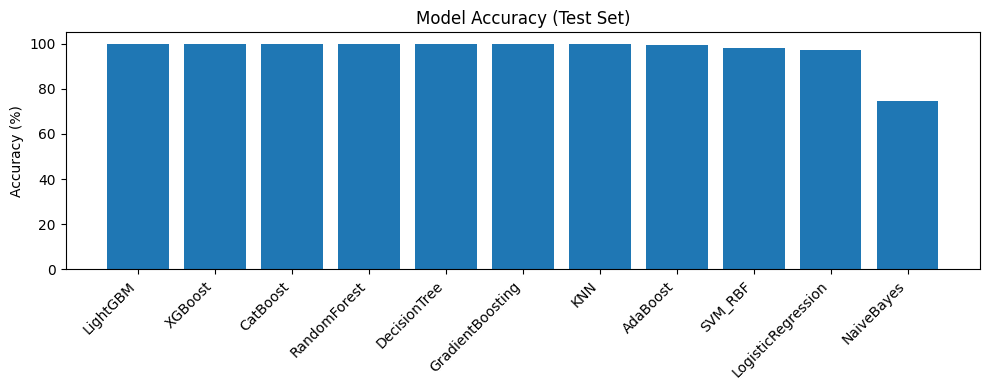

In [11]:

plt.figure(figsize=(10, 4))
plt.bar(results_df["Model"], results_df["Accuracy (%)"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy (Test Set)")
plt.tight_layout()
plt.show()


## 9) Pick top-2 models and export
We export the top-2 models (by accuracy) and the metadata required for inference: base feature order, correlation-filtered features, scaler, RFE mask.


In [12]:

top2 = results_df.head(2)["Model"].tolist()
print("Top 2 models:", top2)

best_name = top2[0]
second_name = top2[1] if len(top2) > 1 else None

best_model = models[best_name]
second_model = models[second_name] if second_name else None

# Refit best/second on full selected training data (train split only) already fit above; keep as-is.
# You may optionally refit on combined train+test if you won't evaluate anymore.

# Export models
joblib.dump(best_model, f"best_model_{best_name}.pkl")
if second_model is not None:
    joblib.dump(second_model, f"second_model_{second_name}.pkl")

# Export metadata (single file)
metadata = {
    "random_state": RANDOM_STATE,
    "sample_frac": SAMPLE_FRAC,
    "corr_filter": CORR_FILTER,
    "corr_thresh": CORR_THRESH,
    "test_size": TEST_SIZE,
    "rfe_top_k": int(selected_mask.sum()),
    "base_features": base_features,                 # before corr filter
    "filtered_features": filtered_features,         # after corr filter (and numeric-only)
    "selected_mask": selected_mask,                 # aligns with filtered_features
    "selected_features": selected_features,
    "scaler": scaler
}
joblib.dump(metadata, "nids_feature_metadata.pkl")

print("✅ Exported:")
print(" -", f"best_model_{best_name}.pkl")
if second_model is not None:
    print(" -", f"second_model_{second_name}.pkl")
print(" - nids_feature_metadata.pkl")


Top 2 models: ['LightGBM', 'XGBoost']
✅ Exported:
 - best_model_LightGBM.pkl
 - second_model_XGBoost.pkl
 - nids_feature_metadata.pkl


## 10) Inference demo on a single CSV row
This shows how to load the model/metadata and run prediction on a new CSV. It also prevents the common **missing base feature** error by adding missing columns.


In [13]:

# ===== Load what we exported =====
meta = joblib.load("nids_feature_metadata.pkl")
model_path = f"best_model_{best_name}.pkl"
model_loaded = joblib.load(model_path)

def prepare_features_for_inference(df_in: pd.DataFrame, meta: dict) -> np.ndarray:
    df_in = df_in.copy()
    df_in.columns = df_in.columns.str.strip()

    # Keep only numeric columns that were in training base_features
    # If your inference CSV contains extra columns, we ignore them.
    # Add missing columns (filled with 0)
    for c in meta["filtered_features"]:
        if c not in df_in.columns:
            df_in[c] = 0

    X_base_inf = df_in[meta["filtered_features"]].select_dtypes(include=[np.number])

    # Scale
    X_scaled_inf = meta["scaler"].transform(X_base_inf)

    # Apply RFE mask (aligned with filtered_features)
    X_sel_inf = X_scaled_inf[:, meta["selected_mask"]]
    return X_sel_inf

# --- Create a sample 1-row dataframe using training means (safe demo) ---
sample_row = X_base_f.mean(numeric_only=True).to_dict()
df_sample = pd.DataFrame([sample_row])

X_inf = prepare_features_for_inference(df_sample, meta)
pred = model_loaded.predict(X_inf)[0]
print("Prediction on sample row:", "ATTACK" if int(pred)==1 else "BENIGN")


Prediction on sample row: BENIGN


C:\Users\DST\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 11) Export an inference CSV template
Use this template to ensure your future CSV has the correct headers.


In [14]:

pd.DataFrame(columns=filtered_features).to_csv("inference_template.csv", index=False)
print("✅ Wrote inference_template.csv with", len(filtered_features), "columns")


✅ Wrote inference_template.csv with 53 columns


## 12) (Optional) RandomForest feature importance on selected features


In [15]:

if "RandomForest" in models:
    rf_final = models["RandomForest"]
    if hasattr(rf_final, "feature_importances_") and len(rf_final.feature_importances_) == len(selected_features):
        fi_df = (pd.DataFrame({"Feature": selected_features, "Importance": rf_final.feature_importances_})
                 .sort_values("Importance", ascending=False)
                 .reset_index(drop=True))
        fi_df.head(20)
    else:
        print("RandomForest not fitted yet or feature_importances_ mismatch.")
else:
    print("RandomForest not in models.")
